## Supervised Example (Neural Network Logistic Regression)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.models import Normal, Bernoulli
from edward.stats import norm, bernoulli
from edward.util import rbf

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot', 'seaborn-white'])
import itertools

import scipy
from scipy.stats import gaussian_kde

In [2]:
ed.set_seed(42)

### Simulate data with nonlinear decision boundary

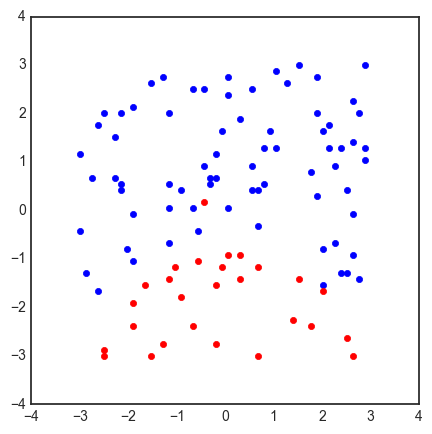

In [3]:
N = 100
D = 2

px1 = np.linspace(-3, 3, 50)
px2 = np.linspace(-3, 3, 50)

px1_m, px2_m = np.mgrid[-3:3:50j, -3:3:50j]

xeval = np.vstack((px1_m.flatten(), px2_m.flatten())).T
x_viz = tf.constant(np.array(xeval, dtype='float32'))

def build_toy_dataset(N):
  x = xeval[np.random.randint(xeval.shape[0],size=N),:]
  y = bernoulli.rvs( p=scipy.stats.logistic.cdf( 5*x[:,0]**2 + 5*x[:,1]**3 ) ) 
  return x, y

x_train, y_train = build_toy_dataset(N)

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()

ax.scatter(x_train[(y_train==1)[0], 0], x_train[(y_train==1)[0],  1], color='b')
ax.scatter(x_train[(y_train==0)[0], 0], x_train[(y_train==0)[0],  1], color='r')

gif = plt.plot
plt.savefig('lr_data.pdf', bbox_inches='tight')

## Neural Network Logistic Model

In [4]:
def neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2):
    h = tf.nn.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.nn.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

L = 2

W_0 = Normal(mu=tf.zeros([D, L]), sigma=tf.ones([D, L]))
W_1 = Normal(mu=tf.zeros([L, L]), sigma=tf.ones([L, L]))
W_2 = Normal(mu=tf.zeros([L, 1]), sigma=tf.ones([L, 1]))
b_0 = Normal(mu=tf.zeros(L), sigma=tf.ones(L))
b_1 = Normal(mu=tf.zeros(L), sigma=tf.ones(L))
b_2 = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

x = tf.convert_to_tensor(x_train, dtype=tf.float32)
y = Bernoulli(logits=neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2))

### Define Variational Approximation Distributions

In [5]:
qW_0 = Normal(mu=tf.Variable(tf.random_normal([D, L])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D, L]))))
qW_1 = Normal(mu=tf.Variable(tf.random_normal([L, L])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L, L]))))
qW_2 = Normal(mu=tf.Variable(tf.random_normal([L, 1])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L, 1]))))
qb_0 = Normal(mu=tf.Variable(tf.random_normal([L])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L]))))
qb_1 = Normal(mu=tf.Variable(tf.random_normal([L])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L]))))
qb_2 = Normal(mu=tf.Variable(tf.random_normal([1])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

data = {y: y_train}
inference = ed.MFVI({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data)

### Run Variational Inference

In [19]:
sess = ed.get_session()
init = tf.initialize_all_variables()
inference.run(n_iter=1000, n_print=100, n_samples=5)

Iteration    1 [  0%]: Loss = 194.850
Iteration  100 [ 10%]: Loss = 37.821
Iteration  200 [ 20%]: Loss = 36.563
Iteration  300 [ 30%]: Loss = 39.428
Iteration  400 [ 40%]: Loss = 45.458
Iteration  500 [ 50%]: Loss = 37.403
Iteration  600 [ 60%]: Loss = 36.024
Iteration  700 [ 70%]: Loss = 37.496
Iteration  800 [ 80%]: Loss = 38.265
Iteration  900 [ 90%]: Loss = 35.820
Iteration 1000 [100%]: Loss = 37.725


### Model Criticism (point-wise evaluations)

In [20]:
y_post = ed.copy(y, {W_0: qW_0.mean(), b_0: qb_0.mean(),       
                     W_1: qW_1.mean(), b_1: qb_1.mean(),
                     W_2: qW_2.mean(), b_1: qb_2.mean()})

In [21]:
print('Log likelihood on training data:')
print(ed.evaluate('log_lik', data={x: x_train, y_post: y_train}))
print()
print('Binary accuracy on training data:')
print(ed.evaluate('binary_accuracy', data={x: x_train, y_post: y_train}))

Log likelihood on training data:
-0.170941

Binary accuracy on training data:
0.81


### Visualize posterior decision boundary

In [22]:
posterior_mean = tf.sigmoid(neural_network(x_viz, qW_0.mean(), qW_1.mean(), qW_2.mean(), 
                                                  qb_0.mean(), qb_1.mean(), qb_2.mean())).eval()
posterior_mean = posterior_mean.reshape(px1.size, px2.size)

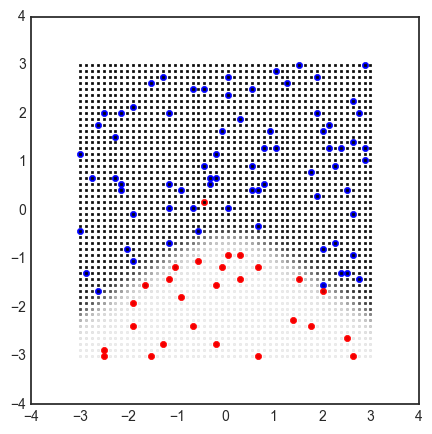

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()

ax.scatter(x_train[(y_train==1)[0], 0], x_train[(y_train==1)[0],  1], color='b')
ax.scatter(x_train[(y_train==0)[0], 0], x_train[(y_train==0)[0],  1], color='r')

for x1 in range(px1.size):
  for x2 in range(px2.size):
    ax.scatter(px1[x1], px2[x2], marker="s", s=3, color='k', alpha=posterior_mean[x1, x2])
    
gif = plt.plot
plt.savefig('lr_nn.pdf', bbox_inches='tight')

## Vanilla Logistic Regression

In [24]:
W = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

x = tf.convert_to_tensor(x_train, dtype=tf.float32)
y = Bernoulli(logits=(ed.dot(x, W) + b))

In [25]:
qW = Normal(mu=tf.Variable(tf.random_normal([D])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [26]:
data = {y: y_train}
inference = ed.MFVI({W: qW, b: qb}, data)

In [27]:
sess = ed.get_session()
init = tf.initialize_all_variables()
inference.run(n_iter=1000, n_print=100, n_samples=5)

Iteration    1 [  0%]: Loss = 159.910
Iteration  100 [ 10%]: Loss = 29.756
Iteration  200 [ 20%]: Loss = 29.102
Iteration  300 [ 30%]: Loss = 28.903
Iteration  400 [ 40%]: Loss = 29.005
Iteration  500 [ 50%]: Loss = 30.240
Iteration  600 [ 60%]: Loss = 31.508
Iteration  700 [ 70%]: Loss = 29.795
Iteration  800 [ 80%]: Loss = 28.998
Iteration  900 [ 90%]: Loss = 29.626
Iteration 1000 [100%]: Loss = 28.932


In [1]:
y_post = ed.copy(y, {W: qW.mean(), b: qb.mean()})

print('Log likelihood on training data:')
print(ed.evaluate('log_lik', data={x: x_train, y_post: y_train}))
print()
print('Binary accuracy on training data:')
print(ed.evaluate('binary_accuracy', data={x: x_train, y_post: y_train}))

NameError: name 'ed' is not defined

In [30]:
posterior_mean = tf.sigmoid(ed.dot(x_viz, qW.mean())+ qb.mean()).eval()
posterior_mean = posterior_mean.reshape(px1.size, px2.size)

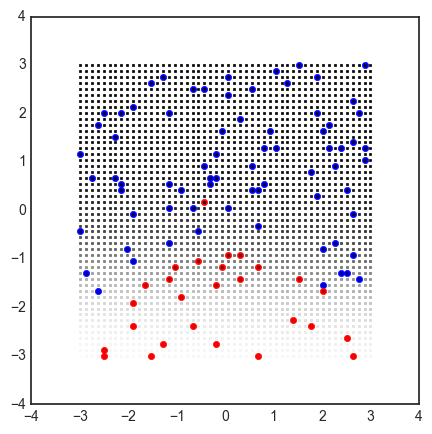

In [31]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()

ax.scatter(x_train[(y_train==1)[0], 0], x_train[(y_train==1)[0],  1], color='b')
ax.scatter(x_train[(y_train==0)[0], 0], x_train[(y_train==0)[0],  1], color='r')

for x1 in range(px1.size):
  for x2 in range(px2.size):
    ax.scatter(px1[x1], px2[x2], marker="s", s=3, color='k', alpha=posterior_mean[x1, x2])
    
gif = plt.plot
plt.savefig('lr_linear.pdf', bbox_inches='tight')